In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
companies = ['nikesupport','xboxsupport','upshelp','comcastcares','amazonhelp','jetblue','americanair',
             'tacobellteam','mcdonalds','kimpton','ihgservice','spotifycares','hiltonhelp','applesupport',
             'microsofthelps','googleplaymusic','scsupport','pandorasupport','hoteltonightcx','dunkindonuts',
             'jackbox','chipotletweets','askpanera','carlsjr','att','tmobilehelp','sprintcare','verizonsupport',
             'boostcare','uscellularcares','alaskaair','virginamerica','virginatlantic','delta','british_airways',
             'southwestair','awssupport','twittersupport','askplaystation','neweggservice','dropboxsupport',
             'hpsupport','atviassist','azuresupport','nortonsupport','dellcares','hulu_support','askrobinhood',
             'officesupport','arbyscares','pearsonsupport','yahoocare','idea_cares','airtel_care','coxhelp',
             'kfc_uki_help','asurioncares','adobecare','glocare','sizehelpteam','airasiasupport','safaricom_care',
             'oppocarein','bofa_help','chasesupport','askciti','ask_wellsfargo','keybank_help','moo','centurylinkhelp',
             'mediatemplehelp','godaddyhelp','postmates_help','doordash_help','airbnbhelp','uber_support','asklyft',
             'askseagate','ask_spectrum','askpaypal','asksalesforce','askvirginmoney','askdsc','askpapajohns','askrbc',
             'askebay','asktigogh','vmucare','askamex','ask_progressive','mtnc_care','askvisa','tesco','sainsburys',
             'walmart','asktarget','morrisons','aldiuk','argoshelpers','greggsofficial','marksandspencer','virgintrains',
             'nationalrailenq','sw_help','londonmidland','gwrhelp','tfl','o2']

## Functions

### Display Topics

In [4]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [5]:
def display_topics2(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

### Topic Distribution

In [6]:
def topic_distribution(df,model):
    unique_tweets = list(set(df.tweet_id))
    topic_list = []
    for tweet in unique_tweets:
        topic_mean = np.mean(model[df['tweet_id'] == tweet], axis=0)
        #print(max(topic_mean))
        itemindex = np.where(topic_mean==max(topic_mean))
        itemindex = topic_mean.argsort()[-3:][::-1]
        #print (int(itemindex[0]))
        topic_tweet = {"tweet_count":tweet,"tweet_category":int(itemindex[0])}
        topic_list.append(topic_tweet)
    
    topics_df = pd.DataFrame(topic_list) 
    topics_df.head(30)
    topicGroup = topics_df.groupby('tweet_category').tweet_count.count().reset_index()
    topicGroup.sort_values('tweet_count',ascending=False, inplace=True)
    
    return topicGroup

In [7]:
def topic_distribution2(df,model):
    unique_tweets = list(set(df.tweet_id_x))
    topic_list = []
    for tweet in unique_tweets:
        topic_mean = np.mean(model[df['tweet_id_x'] == tweet], axis=0)
        #print(max(topic_mean))
        itemindex = np.where(topic_mean==max(topic_mean))
        itemindex = topic_mean.argsort()[-3:][::-1]
        #print (int(itemindex[0]))
        topic_tweet = {"tweet_count":tweet,"tweet_category":int(itemindex[0])}
        topic_list.append(topic_tweet)
    
    topics_df = pd.DataFrame(topic_list) 
    topics_df.head(30)
    topicGroup = topics_df.groupby('tweet_category').tweet_count.count().reset_index()
    topicGroup.sort_values('tweet_count',ascending=False, inplace=True)
    
    return topicGroup

### Stop Words

In [8]:
c = [word.lower() for word in companies]

In [106]:
stop = set(stopwords.words('english')+ \
    ['rt','amp', 'via', 'one', 'around', 'would', 'let', 'could', 'going', 'like', 'get', 'may', 'says', 'say', 'make',
        'based', 'even', 'another', 'completely', 'way', 'find', 'used', 'thing', '2017', 'see', 'need',
        'know','knows', 'think', 'thinks', 'take', 'new', 'day', 'days','https','co','dm','us','look', 'hi','tried'
    'want','send','still','back','hello','using','tried','link','thanks','thank','error','help','please','issue',
    'assistance','support','details','name','address','reply','assist','ijkhelp','since','go','got','getting',
    'setting','really']+c)


In [10]:
exclude = set(string.punctuation)

In [11]:
lemma = WordNetLemmatizer()

In [12]:
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

### Get Topics

In [13]:
def get_topics(company,k,d,mindf=1,maxdf=1.0,c=companies,stop=stop):
    ''' Takes a company and then runs NMF to get the topics. 
    Returns model and feature names.
    
    Parameters:
    company: str name of company 
    k: int components for nmf
    d: dataframe containing tweets'''
    c = [word.lower() for word in c]
    stop = list(stop)
    stop.extend(c)
    stop = set(stop)
    
    companyDF = d[d['author_id'].str.contains(company) | d['text'].str.contains(company)]
    print('dataframe shape:',companyDF.shape)
    
    func_tf_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=maxdf,min_df=mindf)
    func_tf = func_tf_vectorizer.fit_transform(companyDF.text)
    func_tf_feature_names = func_tf_vectorizer.get_feature_names()
    func_nmf = NMF(n_components=k, init='random')
    func_nmf_fit = func_nmf.fit_transform(func_tf)
    
    topic_dist = topic_distribution(companyDF,func_nmf_fit)
    
    return func_nmf,func_tf_feature_names, topic_dist

In [14]:
def get_topics_customer(company,k,d,mindf=1,maxdf=1.0,c=companies,stop=stop):
    ''' Takes a company and then runs NMF to get the topics. 
    Returns model and feature names.
    
    Parameters:
    company: str name of company 
    k: int components for nmf
    d: dataframe containing tweets'''
    c = [word.lower() for word in c]
    stop = list(stop)
    stop.extend(c)
    stop = set(stop)
    
    companyDF = d[d['author_id_y'].str.contains(company)]
    print('dataframe shape:',companyDF.shape)
    
    func_tf_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=maxdf,min_df=mindf)
    func_tf = func_tf_vectorizer.fit_transform(companyDF.text_x)
    func_tf_feature_names = func_tf_vectorizer.get_feature_names()
    func_nmf = NMF(n_components=k, init='random')
    func_nmf_fit = func_nmf.fit_transform(func_tf)
    
    topic_dist = topic_distribution2(companyDF,func_nmf_fit)
    
    return func_nmf,func_tf_feature_names, topic_dist

In [15]:
def get_topics_company(company,k,d,mindf=1,maxdf=1.0,c=companies,stop=stop):
    ''' Takes a company and then runs NMF to get the topics. 
    Returns model and feature names.
    
    Parameters:
    company: str name of company 
    k: int components for nmf
    d: dataframe containing tweets'''
    c = [word.lower() for word in c]
    stop = list(stop)
    stop.extend(c)
    stop = set(stop)
    
    companyDF = d[d['author_id_y'].str.contains(company)]
    print('dataframe shape:',companyDF.shape)
    
    func_tf_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=maxdf,min_df=mindf)
    func_tf = func_tf_vectorizer.fit_transform(companyDF.text_y)
    func_tf_feature_names = func_tf_vectorizer.get_feature_names()
    func_nmf = NMF(n_components=k, init='random')
    func_nmf_fit = func_nmf.fit_transform(func_tf)
    
    topic_dist = topic_distribution2(companyDF,func_nmf_fit)
    
    return func_nmf,func_tf_feature_names, topic_dist

In [16]:
def multi_get_topics(companyDF,k,mindf=1,maxdf=1.0,c=companies,stop=stop):
    ''' Takes a company and then runs NMF to get the topics. 
    Returns model and feature names.
    
    Parameters:
    company: str name of company 
    k: int components for nmf
    d: dataframe containing tweets'''

    c = [word.lower() for word in c]
    stop = list(stop)
    stop.extend(c)
    stop = set(stop)
    
#     companyDF = d[d['author_id'].str.contains(company) | d['text'].str.contains(company)]
#     print('dataframe shape:',companyDF.shape)
    
    func2_tf_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=maxdf,min_df=mindf)
    func2_tf = func2_tf_vectorizer.fit_transform(companyDF.text)
    func2_tf_feature_names = func2_tf_vectorizer.get_feature_names()
    func2_nmf = NMF(n_components=k, init='random')
    func2_nmf_fit = func2_nmf.fit_transform(func2_tf)
    
    topic2_dist = topic_distribution2(companyDF,func2_nmf_fit)
    
    return func2_nmf,func2_tf_feature_names, topic2_dist

In [17]:
def multi_get_topics_customer(companyDF,k,mindf=1,maxdf=1.0,c=companies,stop=stop):
    ''' Takes a company and then runs NMF to get the topics. 
    Returns model and feature names.
    
    Parameters:
    company: str name of company 
    k: int components for nmf
    d: dataframe containing tweets'''

    c = [word.lower() for word in c]
    stop = list(stop)
    stop.extend(c)
    stop = set(stop)
    
#     companyDF = d[d['author_id'].str.contains(company) | d['text'].str.contains(company)]
#     print('dataframe shape:',companyDF.shape)
    
    func2_tf_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=maxdf,min_df=mindf)
    func2_tf = func2_tf_vectorizer.fit_transform(companyDF.text_x)
    func2_tf_feature_names = func2_tf_vectorizer.get_feature_names()
    func2_nmf = NMF(n_components=k, init='random')
    func2_nmf_fit = func2_nmf.fit_transform(func2_tf)
    
    topic2_dist = topic_distribution2(companyDF,func2_nmf_fit)
    
    return func2_nmf,func2_tf_feature_names, topic2_dist

### Get Industry DataFrame

In [18]:
def get_industry(companylist,data):
    industryDF = pd.DataFrame()
    for company in companylist:
        newDF = data[data['author_id'].str.contains(company) | data['text'].str.contains(company)]
        print(newDF.shape)
        industryDF = industryDF.append(newDF)
        
    return industryDF

In [19]:
def get_industry_io(companylist,data):
    industryDF = pd.DataFrame()
    for company in companylist:
        newDF = data[data['author_id_y'].str.contains(company)]
        print(newDF.shape)
        industryDF = industryDF.append(newDF)
        
    return industryDF

### Lemmatize and Tokenize

In [20]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

### Process Tweet Text

In [100]:
def process_tweet_text(tweet, stop=stop):
    if tweet.startswith('@null'):
        return "[Tweet not available]"
    tweet = re.sub(r'\$\w*','',tweet) # Remove tickers
    tweet = re.sub(r'https?:\/\/.*\/\w*','',tweet) # Remove hyperlinks
    tweet = re.sub(r'['+string.punctuation+']+', ' ',tweet) # Remove puncutations like 's
    twtok = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = twtok.tokenize(tweet)
    tokens = [i.lower() for i in tokens if i not in stop and len(i) > 2 and  
                                             i in english_vocab]
    return ",".join(tokens)

## Update Data

In [173]:
df = pd.read_csv('../data/twcs.csv')

In [174]:
df.columns.tolist()

['tweet_id',
 'author_id',
 'inbound',
 'created_at',
 'text',
 'response_tweet_id',
 'in_response_to_tweet_id']

In [176]:
df.shape

(2811774, 8)

In [175]:
df['date'] = pd.to_datetime(df.created_at)

In [177]:
df['time'] = df.date.dt.time

In [178]:
df['month'] = df.date.dt.month

In [179]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,date,time,month
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,2017-10-31 22:10:47,22:10:47,10
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,2017-10-31 22:11:45,22:11:45,10
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,2017-10-31 22:08:27,22:08:27,10
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,2017-10-31 21:54:49,21:54:49,10
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,2017-10-31 21:49:35,21:49:35,10


In [180]:
df.to_pickle('../data/tweets.pkl')

## Import Pickle

In [181]:
df = pd.read_pickle('../data/tweets.pkl')

In [182]:
df.columns.tolist()

['tweet_id',
 'author_id',
 'inbound',
 'created_at',
 'text',
 'response_tweet_id',
 'in_response_to_tweet_id',
 'date',
 'time',
 'month']

## Text Processing

In [157]:
mobilelist = ['ATT','TMobileHelp','sprintcare','VerizonSupport']

In [158]:
mobileDF.shape

(35666, 24)

In [ ]:
# mobileDF = get_industry_io()

In [159]:
doc_clean = [clean(doc).split() for doc in mobileDF.text_x]  

In [160]:
doc_clean[1][:]

['yo',
 'att',
 'international',
 'data',
 'plan',
 'give',
 'u',
 '200',
 'mb',
 'thats',
 'selfie',
 '5',
 'tweet']

## Quick LDA

In [145]:
import gensim
from gensim import corpora

In [161]:
dictionary = corpora.Dictionary(doc_clean)

In [162]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [163]:
lda = gensim.models.ldamodel.LdaModel

In [167]:
%time ldamodel = lda(doc_term_matrix, num_topics=20, id2word = dictionary, passes=10)

CPU times: user 7min 21s, sys: 0 ns, total: 7min 21s
Wall time: 7min 20s


In [168]:
print(ldamodel.print_topics(num_topics=20, num_words=3))

[(0, '0.072*"internet" + 0.059*"data" + 0.043*"outage"'), (1, '0.112*"97623" + 0.073*"96206" + 0.043*"service"'), (2, '0.178*"verizonsupport" + 0.079*"sprintcare" + 0.037*"97623"'), (3, '0.053*"phone" + 0.031*"store" + 0.028*"tmobilehelp"'), (4, '0.036*"told" + 0.028*"96206" + 0.023*"hate"'), (5, '0.057*"yall" + 0.050*"fucking" + 0.032*"question"'), (6, '0.232*"96138" + 0.039*"number" + 0.021*"fios"'), (7, '0.034*"website" + 0.033*"app" + 0.026*"8"'), (8, '0.107*"iphone" + 0.065*"x" + 0.060*"98159"'), (9, '0.031*"bill" + 0.024*"speed" + 0.021*"pay"'), (10, '0.085*"service" + 0.069*"97623" + 0.055*"worst"'), (11, '0.071*"account" + 0.030*"someone" + 0.021*"business"'), (12, '0.038*"anyone" + 0.036*"email" + 0.023*"else"'), (13, '0.024*"buy" + 0.023*"tech" + 0.018*"everything"'), (14, '0.033*"97623" + 0.027*"contract" + 0.026*"wtf"'), (15, '0.027*"love" + 0.022*"96208" + 0.017*"great"'), (16, '0.140*"service" + 0.132*"customer" + 0.021*"horrible"'), (17, '0.046*"2" + 0.033*"hour" + 0.032

In [169]:
for topic in ldamodel.show_topics(num_topics=20, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['internet', 'data', 'outage', 'tv', 'slow', 'lte']
Topic 1: Words: 
['97623', '96206', 'service', 'i’m', 'phone', 'pay']
Topic 2: Words: 
['verizonsupport', 'sprintcare', '97623', 'time', 'phone', 'y’all']
Topic 3: Words: 
['phone', 'store', 'tmobilehelp', 'help', '30', 'sent']
Topic 4: Words: 
['told', '96206', 'hate', 'me', 'answer', '97609']
Topic 5: Words: 
['yall', 'fucking', 'question', 'there', 'asap', 'check']
Topic 6: Words: 
['96138', 'number', 'fios', 'update', 'change', 'shitty']
Topic 7: Words: 
['website', 'app', '8', 'trying', 'i️', 'working']
Topic 8: Words: 
['iphone', 'x', '98159', '101675', 'order', 'uscellularcares']
Topic 9: Words: 
['bill', 'speed', 'pay', 'router', 'phone', 'fee']
Topic 10: Words: 
['service', '97623', 'worst', 'suck', 'ever', 'better']
Topic 11: Words: 
['account', 'someone', 'business', 'talk', 'phone', 'plan']
Topic 12: Words: 
['anyone', 'email', 'else', 'next', 'saying', 'ordered']
Topic 13: Words: 
['buy', 'tech', 'everyth

In [170]:
joblib.dump(ldamodel, '../models/lda.pkl')

['../models/lda.pkl']

## Multicore LDA

In [149]:
from gensim import corpora, models

In [150]:
mlda = models.LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10, workers=15)

In [151]:
print(mlda.print_topics(num_topics=5, num_words=3))

[(0, '0.013*"tesco" + 0.012*"order" + 0.010*"delivery"'), (1, '0.032*"flight" + 0.020*"delta" + 0.017*"americanair"'), (2, '0.025*"service" + 0.018*"customer" + 0.009*"phone"'), (3, '0.015*"account" + 0.010*"app" + 0.009*"card"'), (4, '0.036*"applesupport" + 0.026*"95974" + 0.018*"iphone"')]


In [152]:
for topic in mlda.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['tesco', 'order', 'delivery', 'train', 'today', 'store']
Topic 1: Words: 
['flight', 'delta', 'americanair', 'southwestair', 'britishairways', 'seat']
Topic 2: Words: 
['service', 'customer', 'phone', 'call', 'time', 'internet']
Topic 3: Words: 
['account', 'app', 'card', 'email', 'cant', 'help']
Topic 4: Words: 
['applesupport', '95974', 'iphone', 'update', 'i️', 'phone']


## LDA with SKLEARN

### Count Vectorizer

In [154]:
cv_vectorizer = CountVectorizer(stop_words=stop)
cv = cv_vectorizer.fit_transform(ioDF.text_x)
cv_feature_names = cv_vectorizer.get_feature_names()

In [156]:
lda = LatentDirichletAllocation(n_topics=5, max_iter=10, learning_method='online', learning_offset=50.,random_state=0,n_jobs=-1).fit(cv)

/home/xavier/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
Process ForkPoolWorker-55:
Traceback (most recent call last):
  File "/home/xavier/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xavier/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xavier/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/xavier/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
  File "/home/xavier/anaconda3/lib/python3.6/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
  File "/home/xavier/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/num

OSError: [Errno 28] No space left on device

In [ ]:
print(lda.print_topics(num_topics=5, num_words=3))

In [ ]:
for topic in lda.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

## Quick NMF

### TF-IDF

In [90]:
tf = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=.6,min_df=.05)
x = tf.fit_transform(appleDF.text)
tf_feature_names = tf.get_feature_names()

In [91]:
print(x.shape)

(171517, 14)


In [92]:
nmf = NMF(n_components=5, init='random')
nmf_fit = nmf.fit_transform(x)

In [93]:
joblib.dump(nmf, '../models/nmf.pkl')

['../models/nmf.pkl']

In [94]:
display_topics(nmf,tf_feature_names,6)

Topic 0:
help happy device using version issue
Topic 1:
iphone ios version using device apple
Topic 2:
please happy device apple version using
Topic 3:
phone apple update ios using work
Topic 4:
update issue work software device ios


## Model with Just Customer Tweets

In [183]:
ioDF = pd.read_pickle('../data/io.pkl')

### Tech Customer Topics

In [184]:
techioDF = get_industry_io(techlist,ioDF)

(74632, 27)
(4695, 27)
(3049, 27)
(5875, 27)


In [185]:
techioNMF,techioFeatures,techioDist = multi_get_topics_customer(techioDF,20,stop=stop,c=companies)

In [186]:
display_topics(techioNMF,techioFeatures,6)

Topic 0:
ios updating bug slow ipad bugs
Topic 1:
iphone plus screen anyone slow else
Topic 2:
letter type eye without weird use
Topic 3:
printer hpprnt hppsdr print hpcswus hp
Topic 4:
battery life draining fast drain drains
Topic 5:
keeps freezing crashing apps turning keep
Topic 6:
wtf wrong yo happening went deleted
Topic 7:
question mark box hppsdr marks type
Topic 8:
problem fixed gonna anyone else solve
Topic 9:
shit together fucking fuck yo tired
Topic 10:
updated ever boxes seeing marks emojis
Topic 11:
fix gonna asap bug damn pls
Topic 12:
apple music watch id pay account
Topic 13:
hey guys siri fuck stop wanna
Topic 14:
annoying really getting keep bug fucking
Topic 15:
time every screen try type minutes
Topic 16:
phone fucking slow calls fuck charge
Topic 17:
glitch fixed keyboard stupid damn gonna
Topic 18:
app working store apps download work
Topic 19:
update latest last software apps ever


### Apple Specific

In [187]:
apple2NMF,apple2Features,apple2Dist = get_topics_customer('AppleSupport',10,ioDF,maxdf=.6,stop=stop)

dataframe shape: (74632, 27)


In [188]:
display_topics(apple2NMF,apple2Features,6)

Topic 0:
phone updated freezing keeps ever fucking
Topic 1:
iphone plus keeps screen freezing anyone
Topic 2:
shit together fucking fuck yo annoying
Topic 3:
apple music app watch store working
Topic 4:
question mark letter type box marks
Topic 5:
ios battery life draining fast drain
Topic 6:
fix glitch gonna bug damn asap
Topic 7:
hey problem fixed guys gonna type
Topic 8:
update latest apps last software slow
Topic 9:
wtf wrong yo happening went deleted


In [189]:
apple2Dist

,tweet_category,tweet_count
0,0,15834
3,3,13738
1,1,11130
5,5,7224
8,8,6338
4,4,5736
6,6,5337
2,2,3225
9,9,3089
7,7,2962


### Apple 2

In [27]:
from datetime import datetime

In [25]:
appleNew = pd.read_pickle('../data/apple.pkl')

In [28]:
apple_tweets = appleNew.loc[appleNew.date_x > datetime(2017, 10, 31)]

In [107]:
cleanApple = apple_tweets.copy()

In [108]:
cleanApple['text_x'] = cleanApple.text_x.apply(lambda x: process_tweet_text(x))

In [109]:
cleanApple.to_pickle('../data/cleanAppleFiltered.pkl')

In [31]:
a2NMF,a2Features,a2Dist = get_topics_customer('AppleSupport',10,cleanApple,maxdf=.6,stop=stop)

dataframe shape: (46061, 27)


In [32]:
display_topics(a2NMF,a2Features,6)

Topic 0:
phone keep freezing slow seeing stop
Topic 1:
letter eye use weird keyboard symbol
Topic 2:
battery life drain fast check last
Topic 3:
problem fixed else yet apple needs
Topic 4:
question mark box seeing keep tired
Topic 5:
time every working screen work apple
Topic 6:
annoying really getting bug together fixed
Topic 7:
type without happening try weird whenever
Topic 8:
update latest last slow work recent
Topic 9:
fix bug damn keyboard already situation


In [33]:
a2Dist

,tweet_category,tweet_count
5,5,11722
0,0,8278
9,9,6842
6,6,4635
2,2,3894
8,8,3194
1,1,2205
4,4,2017
3,3,1875
7,7,1384


## Apple LDA

In [35]:
import gensim
from gensim import corpora

Slow version of gensim.models.doc2vec is being used


In [101]:
apple_clean= [process_tweet_text(doc).split() for doc in apple_tweets.text_x]  

In [102]:
apple_clean[:1]

[['wrong,keyboard']]

In [91]:
dictionary = corpora.Dictionary(apple_clean)

In [92]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in apple_clean]

In [93]:
lda = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=15, id2word = dictionary, passes=10)

In [94]:
print(lda.print_topics(num_topics=10, num_words=3))

[(6, '0.032*"update,phone" + 0.025*"major,bug,phone,showing,signal,getting,airplane,mode,security" + 0.025*"continuity,work"'), (12, '0.023*"inquire,something,regarding,refund,item" + 0.023*"dont,care,feature,life,battery" + 0.023*"private,message"'), (11, '0.026*"phone,weird,ass,ever,latest,update,explain" + 0.026*"sort,server,keep,delete,good,chocolate,teapot,sake" + 0.009*"fixed"'), (8, '0.024*"anyway,check,battery,health" + 0.024*"headphone,inside,ear,mighty,headache" + 0.024*"anyone,else,person,goes,saying,stay,read,sit,thinking,message,read"'), (3, '0.025*"open" + 0.025*"letter,broken" + 0.025*"screen,goes,dark,brightness,disabled,goes,dark"'), (4, '0.025*"idea,duplicate,copy,work,request,sheet,recent,work,carried,lost,original" + 0.025*"reset,phone,none" + 0.007*"work"'), (2, '0.026*"stupid,update,freezing,phone" + 0.006*"update,fix" + 0.005*"fix,letter"'), (5, '0.025*"literally,month,already,broke,replacement" + 0.025*"fix,running,incredibly,slow,last,update,hit,button,later,fi

In [95]:
for topic in lda.show_topics(num_topics=10, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 1: Words: 
['ever,phone,auto,correcting,freezing,type', 'anyone,else,capital', 'fix,fact,type,without,turning', 'stuck,update,loop,recent,upgrade,access', 'perpetually,never,finishing,plenty,storage,space', 'making,useless']
Topic 10: Words: 
['love,second,everything,working,next,use,anything,turn', 'phone,hot,mess,today,comes,phone,last,tweet', 'annoying', 'con', 'hell', 'beta']
Topic 13: Words: 
['hide,notification,text,hide,text,hide,whole,text', 'apple', 'check', 'fix,bug', 'downgrade', 'came']
Topic 8: Words: 
['anyway,check,battery,health', 'headphone,inside,ear,mighty,headache', 'anyone,else,person,goes,saying,stay,read,sit,thinking,message,read', 'phone,working,sort,paying', 'default,layout,progress,default', 'citizen,currently,lost,stolen,want,buy,replacement,year,warranty,work']
Topic 9: Words: 
['already,update', 'train,return,rightful,owner', 'excuse,phone', 'update,use,store,always,ask,user,password,accept', 'act,together,custom,defective,horrific,customer,service,tr

## Apple LDA SKLearn

In [59]:
cv_vectorizer = CountVectorizer(stop_words=stop)
cv = cv_vectorizer.fit_transform(cleanApple.text_x)
cv_feature_names = cv_vectorizer.get_feature_names()

In [60]:
ldaSK = LatentDirichletAllocation(n_topics=5, max_iter=10, learning_method='online', learning_offset=50.,random_state=0,n_jobs=-1).fit(cv)

/home/xavier/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [61]:
from wordcloud import WordCloud, STOPWORDS

In [96]:
# for t in range(lda.num_topics):
#     plt.figure()
#     plt.imshow(WordCloud().fit_words(lda.show_topic(t, 20)))
#     plt.axis("off")
#     plt.title("Topic #" + str(t))
#     plt.show()

In [97]:
for i in range(10, lda.num_topics):
    with open('output_file.txt', 'w') as outfile:
        outfile.write('{}\n'.format('Topic #' + str(i + 1) + ': '))
        for word, prob in lda.show_topic(i, topn=20):
            outfile.write('{}\n'.format(word.encode('utf-8')))
        outfile.write('\n')

## Clean Southwest

In [116]:
sw = pd.read_pickle('../data/soutwest.pkl')

In [117]:
sw_tweets = sw.loc[sw.date_x > datetime(2017, 11, 26)]

In [118]:
cleanSW = sw_tweets.copy()

In [119]:
cleanSW['text_x'] = cleanSW.text_x.apply(lambda x: process_tweet_text(x))

In [120]:
cleanSW.to_pickle('../data/cleanSWFiltered.pkl')

### Activision

In [193]:
#ATVIAssist 
atNMF,atFeatures,atDist= get_topics_customer('ATVIAssist',15,ioDF,stop=stop)

dataframe shape: (10279, 27)


In [194]:
display_topics(atNMF,atFeatures,8)

Topic 0:
game every fucking time broken disconnected lobby restart
Topic 1:
cod points wwii digital bought deluxe edition received
Topic 2:
pass season download dlc iw pay warfare infinite
Topic 3:
supply drops drop rare lost open keys zombies
Topic 4:
servers connect fucking disconnected dedicated guys pc ffs
Topic 5:
play online able cant multiplayer friends connect trying
Topic 6:
update coming failure restart pc next last today
Topic 7:
black screen party ops match every loading lobby
Topic 8:
glitch hoc du pointe map point patch people
Topic 9:
pre order ordered download bonus token unlock digital
Topic 10:
fix shit fucking plz pls spawns guys damn
Topic 11:
xbox call duty headquarters wwii connect hq live
Topic 12:
xp double level prestige token reset orders unlock
Topic 13:
code online redeem redeemed connect work multiplayer failure
Topic 14:
getting keep disconnected keys kicked server games trying


In [195]:
atDist

,tweet_category,tweet_count
0,0,1498
12,12,1169
5,5,790
10,10,770
14,14,717
7,7,622
1,1,604
8,8,579
11,11,569
3,3,516


#### Apple Clean

In [219]:
appleCleanNMF,appleCleanFeatures,appleCleanDist= get_topics_customer('AppleSupport',10,cleanIODF,stop=stop)

dataframe shape: (74632, 27)


In [220]:
display_topics(appleCleanNMF,appleCleanFeatures,6)

Topic 0:
fix damn keyboard already situation tired
Topic 1:
working time every work screen music
Topic 2:
phone freezing slow ever times charge
Topic 3:
update latest last slow ever freezing
Topic 4:
question mark box seeing tired damn
Topic 5:
bug fixed keyboard screen apple stupid
Topic 6:
letter type eye weird without use
Topic 7:
battery life fast drain last charge
Topic 8:
annoying getting keep really freezing together
Topic 9:
problem fixed else apple anyone solve


In [221]:
appleCleanDist

,tweet_category,tweet_count
1,1,25138
2,2,8043
3,3,7030
9,9,6749
7,7,6397
8,8,6293
0,0,6099
5,5,3286
6,6,3097
4,4,2481


### Microsoft Specific

In [111]:
micro2NMF,micro2Features,micro2Dist = get_topics_customer('MicrosoftHelps',10,ioDF,stop=stop)

dataframe shape: (3634, 24)


In [114]:
display_topics(micro2NMF,micro2Features,10)

Topic 0:
laptop getting pc time computer every trying keep updates work
Topic 1:
update fall creators creator latest installed screen win computer issues
Topic 2:
working stopped keyboard updates log edge ideas minecraft stops password
Topic 3:
fix problem screen mouse tell bug ideas fcu black jknmwxcrnj
Topic 4:
surface pro screen pen book battery warranty cracked keyboard replacement
Topic 5:
windows install stuck store hours version update upgrade phone apps
Topic 6:
hey guys office install happen blank contact game screen message
Topic 7:
microsoft store app apps code available try download game office
Topic 8:
account xbox sign live access hotmail cant charged recover someone
Topic 9:
email outlook trying access log someone locked emails unblocked hotmail


In [113]:
micro2Dist

,tweet_category,tweet_count
0,0,674
5,5,333
1,1,308
9,9,270
7,7,231
4,4,226
8,8,226
6,6,181
3,3,171
2,2,137


### Dell

In [94]:
dell2NMF,dell2Features,dell2Dist = get_topics_customer('DellCares',10,ioDF,stop=stop)

dataframe shape: (2277, 24)


In [95]:
display_topics(dell2NMF,dell2Features,6)

Topic 0:
dell xps care resolve afghanistan india
Topic 1:
charger plugged charging plug bought keeps
Topic 2:
computer buy never ever months worst
Topic 3:
service customer worst horrible tag company
Topic 4:
laptop bought happened time first idea
Topic 5:
warranty getting email told much work
Topic 6:
inspiron screen update windows use pc
Topic 7:
order call number working placed ordered
Topic 8:
replaced card requesting intel xps heard
Topic 9:
battery replacement xps want swelling life


In [96]:
dell2Dist

,tweet_category,tweet_count
0,0,189
3,3,147
4,4,147
7,7,138
6,6,133
5,5,116
2,2,103
9,9,84
1,1,23
8,8,20


### HP

In [97]:
hp2NMF,hp2Features,hp2Dist = get_topics_customer('HPSupport',10,ioDF,stop=stop)

dataframe shape: (5074, 24)


In [98]:
display_topics(hp2NMF,hp2Features,6)

Topic 0:
printer connect network computer wireless offline
Topic 1:
hpcswus hpprnt printhead problem getting officejet
Topic 2:
ink black cartridge cartridges replaced color
Topic 3:
print hppsdr color page black test
Topic 4:
hp officejet pro scan hppsdr laptop
Topic 5:
printing hppsdr paper pages black blank
Topic 6:
hpaioi type cartridgefailure password iphone paper
Topic 7:
hpsa hpprnt turn hppc document problem
Topic 8:
type question hppsdr ljhelp ijchelp ask
Topic 9:
text replace question hpprnt ask hpcswus


In [99]:
hp2Dist

,tweet_category,tweet_count
4,4,833
0,0,398
1,1,325
8,8,271
2,2,260
3,3,235
7,7,165
9,9,155
6,6,143
5,5,109


## Mobile Topics

In [70]:
mobileDF = get_industry_io(mobilelist,ioDF)

(1465, 24)
(16634, 24)
(10804, 24)
(5841, 24)
(516, 24)
(406, 24)


In [79]:
mobileNMF,mobileFeatures,mobileDist = multi_get_topics_customer(mobileDF,20,stop=stop,c=companies)

In [80]:
display_topics(techioNMF,techioFeatures,6)

Topic 0:
update ios battery life since draining
Topic 1:
hpprnt printer hpcswus hppsdr print hp
Topic 2:
iphone plus keeps screen since freezing
Topic 3:
apple music app hey store working
Topic 4:
problem fixed gonna anyone solve guys
Topic 5:
phone updated since freezing keeps update
Topic 6:
question mark box marks boxes hppsdr
Topic 7:
fix glitch gonna hey bug damn
Topic 8:
letter type time every eye glitch
Topic 9:
shit together wtf fucking yo fuck


In [81]:
mobileDist

,tweet_category,tweet_count
2,2,5009
1,1,3526
19,19,2007
13,13,1981
16,16,1959
0,0,1950
5,5,1856
14,14,1731
7,7,1539
18,18,1496


## Clean Tweets

In [128]:
# from copy import deepcopy

In [204]:
cleanIODF = ioDF.copy(deep=True)

In [205]:
cleanIODF['text_x'] = cleanIODF.text_x.apply(lambda x: process_tweet_text(x))

In [206]:
cleanIODF.shape

(794299, 27)

### ATT

#### Cleaned

In [207]:
attCleanNMF,attCleanFeatures,attCleanDist= get_topics_customer('ATT',10,cleanIODF,stop=stop)

dataframe shape: (1677, 27)


In [208]:
display_topics(attCleanNMF,attCleanFeatures,6)

Topic 0:
service cell outage area bad much
Topic 1:
pay speed money much month full
Topic 2:
customer worst ever service absolute horrible
Topic 3:
limited edition scarf win jersey giver
Topic 4:
call today account time number fix
Topic 5:
store people right outage working experience
Topic 6:
month bill data every plan use
Topic 7:
order status long ship time today
Topic 8:
phone upgrade free keep old sent
Topic 9:
awesome giving soccer away chance win


In [209]:
attCleanDist

,tweet_category,tweet_count
4,4,276
0,0,242
5,5,216
6,6,209
2,2,204
8,8,165
1,1,108
7,7,94
9,9,91
3,3,12


In [210]:
attNMF,attFeatures,attDist = get_topics_customer('ATT',10,ioDF,stop=stop)

dataframe shape: (1677, 27)


In [211]:
display_topics(attNMF,attFeatures,6)

Topic 0:
service cell austin bad area customer
Topic 1:
call account time league justice store
Topic 2:
phone calls working cell hours upgrade
Topic 3:
internet fiber hey speed ethernetport cedarparktowncenter
Topic 4:
edition scarf soccereverywhere limited win jersey
Topic 5:
awesome giving scarves fans soccer chance
Topic 6:
data wifi plan use yo gives
Topic 7:
iphone order iphonex trade pre plus
Topic 8:
pay month bill every money much
Topic 9:
customer worst ever service absolute absolutely


In [87]:
attDist

,tweet_category,tweet_count
1,1,223
2,2,220
3,3,196
6,6,179
9,9,165
7,7,121
8,8,115
4,4,113
5,5,61
0,0,24


### Verizon

In [101]:
vNMF,vFeatures,vDist = get_topics_customer('VerizonSupport',10,ioDF,stop=stop)

dataframe shape: (5841, 24)


In [102]:
display_topics(vNMF,vFeatures,6)

Topic 0:
phone number calls call getting got
Topic 1:
bill pay month trying hey account
Topic 2:
internet working connection speed slow tv
Topic 3:
verizon working wireless customers switch app
Topic 4:
hold minutes call time hour hours
Topic 5:
wifi fix shit sucks hey slow
Topic 6:
worst ever customer company cable guys
Topic 7:
fios tv watch app family love
Topic 8:
service customer terrible horrible sucks worse
Topic 9:
outage area hey ny nj morning


In [103]:
vDist

,tweet_category,tweet_count
1,1,1087
7,7,810
8,8,690
0,0,660
4,4,618
2,2,533
5,5,439
3,3,390
9,9,298
6,6,268


In [100]:
mobilelist

['ATT',
 'TMobileHelp',
 'sprintcare',
 'VerizonSupport',
 'BoostCare',
 'USCellularCares']

### T-Mobile

In [104]:
tmNMF,tmFeatures,tmDist = get_topics_customer('TMobileHelp',10,ioDF,stop=stop)

dataframe shape: (16634, 24)


In [105]:
display_topics(tmNMF,tmFeatures,6)

Topic 0:
service sucks trash area fix shit
Topic 1:
bill pay month trying time app
Topic 2:
customer worst ever years experience time
Topic 3:
order pre trying website iphonex online
Topic 4:
plan line pixel tmobile account lines
Topic 5:
mobile panda express website app working
Topic 6:
phone store unlock upgrade use got
Topic 7:
sent message question email waiting response
Topic 8:
guys hey question fix lte data
Topic 9:
iphone jump preorder jod upgrade trade


In [106]:
tmDist

,tweet_category,tweet_count
4,4,3347
5,5,2074
6,6,1853
8,8,1774
0,0,1682
2,2,1585
1,1,1552
9,9,1448
3,3,790
7,7,356


### Sprint

In [115]:
sprintNMF,sprintFeatures,sprintDist = get_topics_customer('sprintcare',10,ioDF,stop=stop)

dataframe shape: (10804, 24)


In [116]:
display_topics(sprintNMF,sprintFeatures,6)

Topic 0:
phone upgrade want calls call working
Topic 1:
worst ever company absolute literally experience
Topic 2:
customer years call care loyal terrible
Topic 3:
sprint call verizon store iphonex account
Topic 4:
service trash horrible shitty terrible ass
Topic 5:
shit data bill pay month lte
Topic 6:
sucks fucking suck ass bad guys
Topic 7:
iphone order upgrade preorder pre trying
Topic 8:
hate fucking really much fuckin right
Topic 9:
fuck ass shitty trash connection honestly


In [117]:
tmDist

,tweet_category,tweet_count
4,4,3347
5,5,2074
6,6,1853
8,8,1774
0,0,1682
2,2,1585
1,1,1552
9,9,1448
3,3,790
7,7,356


### Airline Compaint Topics

In [222]:
airlist = ['SouthwestAir','Delta','British_Airways','AmericanAir']

In [223]:
airlineDF = get_industry_io(airlist,cleanIODF)

(20986, 27)
(28485, 27)
(19611, 27)
(24506, 27)


In [227]:
airNMF,airFeatures,airDist = multi_get_topics_customer(airlineDF,20,stop=stop,c=companies)

In [228]:
display_topics(airNMF,airFeatures,10)

Topic 0:
great crew trip job experience awesome service amazing start always
Topic 1:
gate agent waiting sitting late tarmac min people board early
Topic 2:
today crew amazing good really awesome work job working happy
Topic 3:
check tomorrow early airport trying bird carry able working line
Topic 4:
change trying booking book ticket call trip getting phone booked
Topic 5:
flying tomorrow never start next experience airport forward lounge year
Topic 6:
service customer terrible call poor disappointed amazing phone worst excellent
Topic 7:
morning early good tomorrow beautiful sunrise view crew start awesome
Topic 8:
plane left sitting board late crew stuck waiting people broken
Topic 9:
upgrade first class business list free trip use comfort economy
Topic 10:
fly never always want every next wait reason use miles
Topic 11:
time last wait every hold first departure next long week
Topic 12:
flight attendant tomorrow miss crew booked connection late tonight next
Topic 13:
seat middle wind

In [229]:
airDist

,tweet_category,tweet_count
4,4,13915
12,12,9676
0,0,5727
1,1,5207
19,19,4807
6,6,4501
17,17,4170
15,15,3693
8,8,3516
9,9,3435


### Company Response Topics

#### Southwest

In [212]:
swNMF,swFeatures,swDist = get_topics_company('SouthwestAir',10,cleanIODF,stop=stop)

dataframe shape: (20986, 27)


In [214]:
display_topics(swNMF,swFeatures,6)

Topic 0:
flight hope enjoy great glad trip
Topic 1:
rewards rapid number account hey na
Topic 2:
confirmation number follow closer sj mind
Topic 3:
free feel vp hear follow info
Topic 4:
sorry hear working possible appreciate delay
Topic 5:
pass kudos along sending mind sure
Topic 6:
happy today vp travels sw onboard
Topic 7:
onboard soon wait welcome forward hope
Topic 8:
sharing skies love view ms great
Topic 9:
boarding check earlybird position specific prior


In [215]:
swDist

,tweet_category,tweet_count
4,4,4598
0,0,3200
7,7,3038
8,8,1770
2,2,1697
9,9,1697
6,6,1375
1,1,1362
3,3,985
5,5,922


#### Sprint Tweets

In [216]:
sprintCompanyNMF,sprintCompanyFeatures,sprintCompanyDist = get_topics_company('sprintcare',10,cleanIODF,stop=stop)

dataframe shape: (12649, 27)


In [217]:
display_topics(sprintCompanyNMF,sprintCompanyFeatures,6)

Topic 0:
issues service zip experiencing code cross
Topic 1:
team concerns happy contact reach information
Topic 2:
hey eg seems shoot lp mm
Topic 3:
want feel definitely wow makes sprint
Topic 4:
hear feedback type kind sorry customers
Topic 5:
concerning really oh allow dp ja
Topic 6:
reaching jm kj much mj gt
Topic 7:
today anything well hope hate sprint
Topic 8:
direct message lc jj je mj
Topic 9:
follow order check something sounds eg


In [218]:
sprintCompanyDist

,tweet_category,tweet_count
0,0,1805
1,1,1805
8,8,1426
2,2,1348
3,3,1272
9,9,996
4,4,883
5,5,793
6,6,733
7,7,616


## Quick Cluster

### Kmeans

In [58]:
#without dimensionality reduction

num_clusters = 5

km = KMeans(n_clusters=num_clusters,init='k-means++',n_init=20,n_jobs=-1,max_iter=100)

%time km.fit(x)

clusters = km.labels_.tolist()

CPU times: user 308 ms, sys: 240 ms, total: 548 ms
Wall time: 7.7 s


In [59]:
joblib.dump(km,  '../models/doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

['../models/doc_cluster.pkl']

In [60]:
appleClusters = appleDF.copy()
appleClusters['clusters'] = clusters

#frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [61]:
appleClusters.clusters.value_counts()

0    93927
2    24611
1    21735
3    19018
4    12226
Name: clusters, dtype: int64

In [62]:
appleClusters.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day,clean,clusters
119,129,AppleSupport,False,@95972 Let's take a look at your flashlight to...,130,131.0,2017-10-04 13:04:26,10,2,"flashlight,together,recently,version,number",1
120,130,95973,True,@AppleSupport @95972 i have the same problem w...,NaN,129.0,2017-10-04 22:10:17,10,2,"problem,led,doesnt,work,since",0
309,385,AppleSupport,False,@96035 We want you to get the most out of your...,NaN,386.0,2017-10-04 12:33:00,10,2,"happening,specifically",3
339,416,AppleSupport,False,"@96041 We appreciate you letting us know, does...",NaN,417.0,2017-10-04 12:59:29,10,2,"appreciate,happen,cellular,data",0
340,417,96041,True,@AppleSupport When you go to the App Store &am...,416,418.0,2017-10-04 04:57:54,10,2,"pick,randomly,image,video,sec,play,whole",0


In [107]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()


Top terms per cluster:

Cluster 0 words:

NameError: name 'vocab_frame' is not defined

### Cosine Similarity

In [75]:
# from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(x)

### PCA Before TSNE?

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(nmf_W)

# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.32311738  0.25988292  0.17274012]


In [81]:
len(pca_result)

171517

### TSNE

In [67]:
tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(nmf_W) 

In [68]:
joblib.dump(tsne_model, '../models/tsne.pkl')

['../models/tsne.pkl']

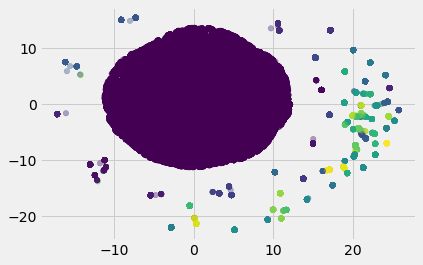

In [69]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50, random_state=0).fit(nmf_W)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans.labels_, marker='o', s=30);

In [ ]:
joblib.dump(kmeans, '../models/kmeans.pkl')

In [65]:
kmeans = joblib.load('../models/kmeans.pkl')

### TSNE Tech Companies

In [24]:
techlist = ['AppleSupport','MicrosoftHelps','DellCares','HPSupport']

(171517, 8)
(17303, 8)
(6359, 8)
(10204, 8)


In [277]:
techDF.shape

(205383, 8)

In [278]:
tf3_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True)
tf3 = tf3_vectorizer.fit_transform(techDF.text)
tf3_feature_names = tf3_vectorizer.get_feature_names()

In [281]:
no_topics = 20
nmf2_model = NMF(n_components=no_topics,init='random').fit(tf3)
nmf2_W = nmf2_model.transform(tf3)
nmf2_H = nmf2_model.components_

In [283]:
tsne_tech_model = TSNE(n_components=2, random_state=0)
results = tsne_tech_model.fit_transform(nmf2_W) 

In [284]:
joblib.dump(tsne_tech_model, '../models/tech_tsne.pkl')

['../models/tech_tsne.pkl']

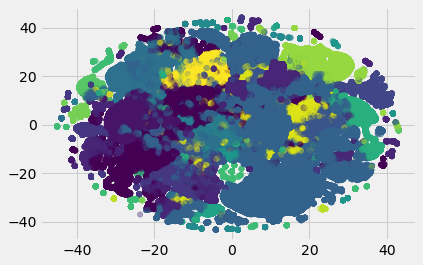

In [285]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=20, random_state=0).fit(nmf2_W)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans2.labels_, marker='o', s=30);

In [25]:
mobilelist = ['ATT','TMobileHelp','sprintcare','VerizonSupport','BoostCare','USCellularCares']

In [26]:
musiclist= ['SpotifyCares','PandoraSupport','GooglePlayMusic']

In [27]:
shoppinglist = ['AmazonHelp','AskTarget','Walmart','NeweggService']

In [ ]:
# foodlist = ['Postmates_Help','']

### TSNE 2

In [82]:
tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(pca_result) 

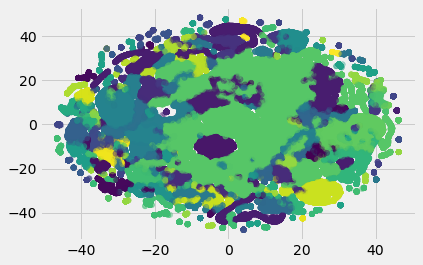

In [83]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)


kmeans2 = KMeans(n_clusters=50, random_state=0).fit(pca_result)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans2.labels_, marker='o', s=30);

In [ ]:
print(kmeans.labels_)

In [ ]:
labels = kmeans.predict(nmf_H)

In [84]:
joblib.dump(tsne_model, '../models/tsne2.pkl')

['../models/tsne2.pkl']